In [35]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.stats import skew, kurtosis, moment

import numpy as np
from scipy.stats import skew, kurtosis, moment
from scipy.fft import fft, ifft

# Assuming 'x' and 'Fbe' are already defined, and 'Fs' is the sampling frequency
# Make sure 'x' is a numpy array (e.g., x = np.array([...]))

def loychikSD_NP(x, Fs, Fbe):
    # Frequency bin centers
    F = Fbe[:-1] + np.diff(Fbe)

    X = fft(x)
    t = np.arange(0, len(x)) / Fs  # equivalent to the original t calculation
    dF = 1 / t[-1]
    Ff = np.arange(0, len(x)) * dF

    # Statistical moments
    M = np.array([
        np.mean(x),
        np.var(x),
        skew(x),
        kurtosis(x),
        moment(x, 1),
        moment(x, 2),
        moment(x, 3)
    ])

    # Initialize result arrays
    Gx = np.zeros(len(F))
    Sx = np.zeros(len(F))
    Kx = np.zeros(len(F))
    M3x = np.zeros(len(F))
    M4x = np.zeros(len(F))
    
    #Kx = M4x/(Gx)^2

    for ii in range(len(F)):
        print(f"{ii + 1} / {len(F)}")  # Counter to determine where you are in run

        # Begin low-pass filter by zeroing bins
        Xn = np.argmax(Ff >= Fbe[ii + 1])  # find the first index where Ff >= Fbe[ii + 1]

        cutX = X[1:Xn]
        XI = np.zeros_like(X)
        XI[1:Xn] = cutX

        # Flipping and conjugating for symmetry
        XI = np.flipud(XI)
        XI[0:Xn - 1] = np.conj(cutX)
        XI = np.flipud(XI)

        xifft = ifft(XI)

        # Extracting the real part of the inverse FFT result
        real_xifft = np.real(xifft)  # this makes sure you're calculating statistics on real numbers

        # Statistical calculations
        Gx[ii] = np.var(real_xifft)
        Sx[ii] = skew(real_xifft)
        Kx[ii] = kurtosis(real_xifft)
        M3x[ii] = moment(real_xifft, 3)
        M4x[ii] = moment(real_xifft, 4)

    return M, F, Gx, Sx, Kx

# The variables Gx, Sx, Kx, M3x, M4x hold the results and can be used as needed



In [42]:
from scipy.signal import butter, filtfilt
from scipy.signal import hann, welch
import numpy as np

Fs = 2000
Tr = 1000  # Primary variable
dF = 1 / Tr

t = np.arange(0, Tr, 1 / Fs)
x = np.random.randn(len(t))

# Interpolation for anti-aliasing
x = np.interp(np.linspace(0, len(x), len(x) * 6), np.arange(len(x)), x)
Fs = 6 * Fs
N = Fs
t = np.arange(0, Tr, 1 / Fs)

x2 = -np.random.lognormal(0, 1, len(x))
x2 = x2 - np.mean(x2)

# Butterworth filtering
b, a = butter(6, 20 / (Fs / 2), btype='high')
x = filtfilt(b, a, x)
x2 = filtfilt(b, a, x2)
b, a = butter(6, 2000 / (Fs / 2))
x = filtfilt(b, a, x)
x2 = filtfilt(b, a, x2)

x3a = x
b, a = butter(6, 20 / (Fs / 2), btype='high')
x3a = filtfilt(b, a, x3a)
b, a = butter(6, 200 / (Fs / 2))
x3a = filtfilt(b, a, x3a)

x3b = x2
b, a = butter(6, 180 / (Fs / 2), btype='high')
x3b = filtfilt(b, a, x3b)
b, a = butter(6, 2000 / (Fs / 2))
x3b = filtfilt(b, a, x3b)

x3a = x3a * 1.05
x3b = x3b * 1.2
x3 = x3a + x3b

f, GxxW1 = welch(x3a, Fs, window=hann(N), nperseg=N)
f, GxxW2 = welch(x3b, Fs, window=hann(N), nperseg=N)
f, GxxW3 = welch(x3, Fs, window=hann(N), nperseg=N)

GxxW = np.column_stack([GxxW1, GxxW2, GxxW3])

In [43]:

from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

xclip1 = x[:Fs*10 + 1]
xclip2 = x2[:Fs*10 + 1]
xclip3 = x3[:Fs*10 + 1]

tclip = np.arange(len(xclip1)) / Fs

# Kernel Density Estimation
ks_density_x = gaussian_kde(x)
ks_density_x2 = gaussian_kde(x2)

faaa = np.linspace(min(x), max(x), 1000)
xaaa = ks_density_x.evaluate(faaa)

faaa2 = np.linspace(min(x2), max(x2), 1000)
xaaa2 = ks_density_x2.evaluate(faaa2)

# If you want to plot, uncomment these lines
# plt.figure()
# plt.subplot(2, 1, 1)
# plt.plot(faaa, xaaa)
# plt.title("KDE for x")

# plt.subplot(2, 1, 2)
# plt.plot(faaa2, xaaa2)
# plt.title("KDE for x2")

# plt.show()

import numpy as np
import scipy.io
import scipy.signal
import scipy.ndimage

# The octspace function is not directly available in Python's standard libraries, you may have to implement it
# Fbe = octspace(10, 6000, 12).center  # Your octave space function
Fbe = np.logspace(np.log10(10), np.log10(6000), 120)  # Placeholder using logspace
Fbe = Fbe  # Assuming Fbe.center in MATLAB just returns Fbe

In [44]:



M, F, Gx, Sx, Kx = loychikSD_NP(x3, Fs, Fbe)

# Power Spectral Density
Gxx = np.gradient(Gx, F)

# Skewness Spectral Density
Sxx = np.gradient(Sx, F)

# Kurtosis Spectral Density
Kxx = np.gradient(Kx, F)

# Fourth Central Moment Spectral Density
# M4xx = np.gradient(Kx * Gx ** 2, F)

# Clear variables
del x, x2, x3

# Save variables
scipy.io.savemat("KSDMixedSignal1000-1.mat", {"M": M, "F": F, "Gx": Gx, "Sx": Sx, "Kx": Kx})

print("MAT file saved. Mission accomplished.")




1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 11

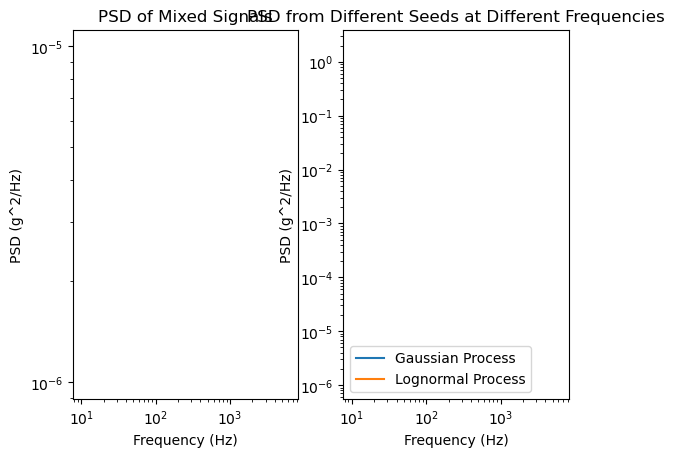

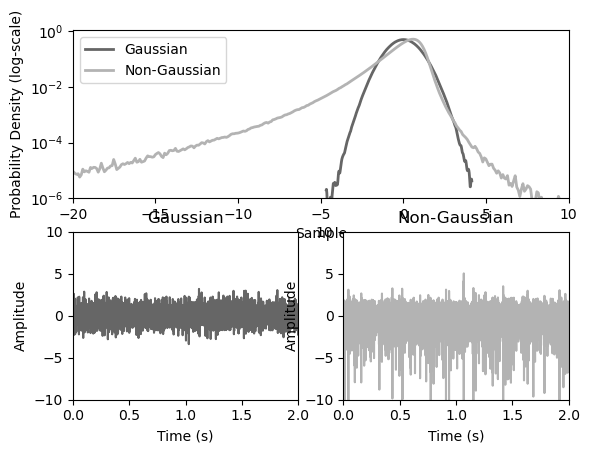

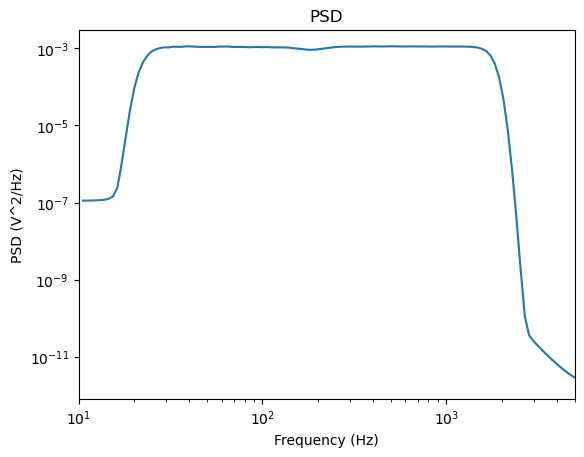

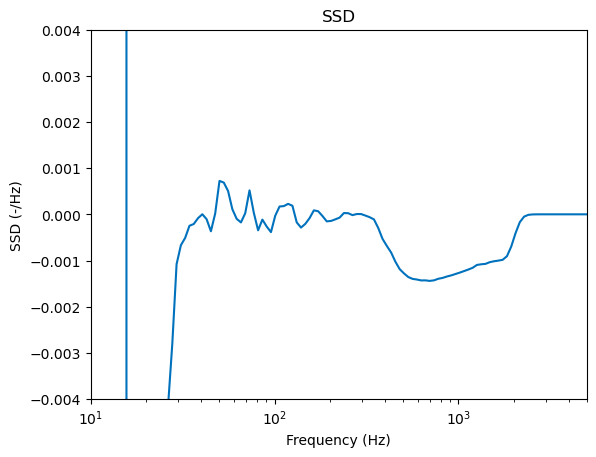

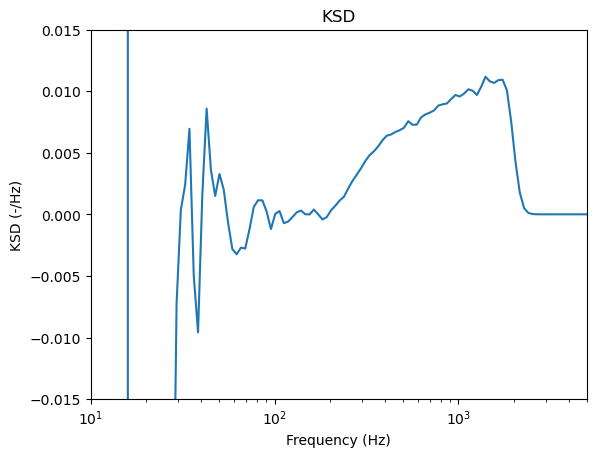

In [45]:
# Graphs

import matplotlib.pyplot as plt
import scipy.io
import numpy as np

# Load MAT file
data = scipy.io.loadmat("/Users/karthikkurella/Documents/Spectral densities/High-order-spectral-densities/src/KSDMixedSignal1000-1.mat")
GxxW = data['Gx']
f = data['F']

# Figure 1
plt.figure(1)

plt.subplot(1, 2, 1)
plt.loglog(f, GxxW[:, 2], linewidth=1.5)
plt.ylabel('PSD (g^2/Hz)')
plt.xlabel('Frequency (Hz)')
plt.title('PSD of Mixed Signals')

plt.subplot(1, 2, 2)
plt.loglog(f, GxxW[:], linewidth=1.5)
plt.ylabel('PSD (g^2/Hz)')
plt.xlabel('Frequency (Hz)')
plt.title('PSD from Different Seeds at Different Frequencies')
plt.legend(['Gaussian Process', 'Lognormal Process'], loc='lower left')

# Figure 2
plt.figure(2)
plt.clf()

plt.subplot(2, 2, (1, 2))
plt.semilogy(faaa, xaaa, linewidth=2, color=[.4, .4, .4])
plt.semilogy(faaa2, xaaa2, linewidth=2, color=[.7, .7, .7])
plt.xlim([-20, 10])
plt.ylim([.000001, 1.1])
plt.ylabel('Probability Density (log-scale)')
plt.xlabel('Sample')
plt.legend(['Gaussian', 'Non-Gaussian'])

# 
# Figure 2 (continued)
plt.subplot(2, 2, 3)
plt.plot(tclip, xclip1, color=[.4, .4, .4])
plt.xlim([0, 2])
plt.ylim([-10, 10])
plt.title('Gaussian')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 4)
plt.plot(tclip, xclip2, color=[.7, .7, .7])
plt.xlim([0, 2])
plt.ylim([-10, 10])
plt.title('Non-Gaussian')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Figure 3
plt.figure(3)
plt.loglog(F, Gxx, f, GxxW[:, 2], linewidth=1.5)
plt.title('PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.xlim([10, 5000])

# Figure 4
plt.figure(4)
plt.semilogx(F, Sxx, linewidth=1.5, color=[0, 0.4470, 0.7410])
plt.title('SSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('SSD (-/Hz)')
plt.xlim([10, 5000])
plt.ylim([-.004, .004])

# Figure 5
plt.figure(5)
plt.semilogx(F, Kxx, linewidth=1.5)
plt.title('KSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('KSD (-/Hz)')
plt.xlim([10, 5000])
plt.ylim([-.015, .015])

plt.show()


In [33]:
print(GxxW[:, 2])

[2.06428818e-07]


# Audio input

In [11]:
from scipy.signal import butter, filtfilt
from scipy.signal import hann, welch
import numpy as np

from scipy.io import wavfile

# Read audio file
#filefolder = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0000.wav")

Fs, audio_data = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0000.wav")

# Use the audio_data as your x3 or whichever variable you want to replace
x3 = audio_data.astype(float)


M, F, Gx, Sx, Kx = loychikSD_NP(x3, Fs, Fbe)

# Power Spectral Density
Gxx = np.gradient(Gx, F)

# Skewness Spectral Density
Sxx1 = np.gradient(Sx, F)

# Kurtosis Spectral Density
Kxx1 = np.gradient(Kx, F)

# Fourth Central Moment Spectral Density
# M4xx = np.gradient(Kx * Gx ** 2, F)

# Clear variables
# del x, x2, x3

# Save variables
scipy.io.savemat("Audio-1.mat", {"M": M, "F": F, "Gx": Gx, "Sx": Sx, "Kx": Kx})

print("MAT file saved. Mission accomplished.")




/var/folders/g8/ryts82jd3c33vl83y_np4dzm0000gn/T/ipykernel_4062/588606318.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, audio_data = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0000.wav")


1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 11

In [12]:
!pwd

/Users/karthikkurella/Documents/Spectral densities/High-order-spectral-densities/src


In [21]:
GxxW[:2]

array([[1.53579269e+11, 3.67814515e+11, 8.27791323e+11, 8.81242775e+11,
        9.61320137e+11, 1.08156151e+12, 1.33663196e+12, 1.39178195e+12,
        1.44498109e+12, 1.45927740e+12, 1.47858092e+12, 1.49050238e+12,
        1.54897671e+12, 1.59641993e+12, 1.77956366e+12, 1.83964744e+12,
        1.85359519e+12, 1.87388636e+12, 1.90953595e+12, 1.91552217e+12,
        1.92013582e+12, 1.92411811e+12, 1.93835041e+12, 1.94735716e+12,
        1.96064957e+12, 1.98287216e+12, 2.01331463e+12, 2.04743219e+12,
        2.05515739e+12, 2.07451408e+12, 2.08687355e+12, 2.09736809e+12,
        2.10231475e+12, 2.10540857e+12, 2.10889546e+12, 2.11181386e+12,
        2.11348538e+12, 2.11434843e+12, 2.11521482e+12, 2.11798346e+12,
        2.11909742e+12, 2.11960267e+12, 2.23925398e+12, 2.24023946e+12,
        2.24105082e+12, 2.24187270e+12, 2.24395054e+12, 2.24495981e+12,
        2.24595576e+12, 2.24721400e+12, 2.24841631e+12, 2.24943823e+12,
        2.25048465e+12, 2.25160963e+12, 2.25468238e+12, 2.355508

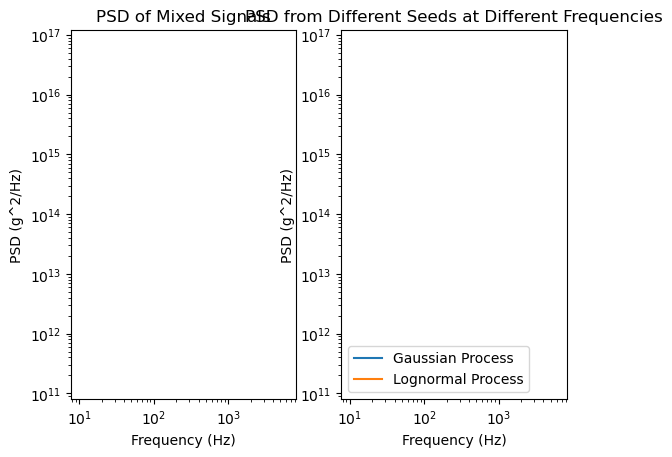

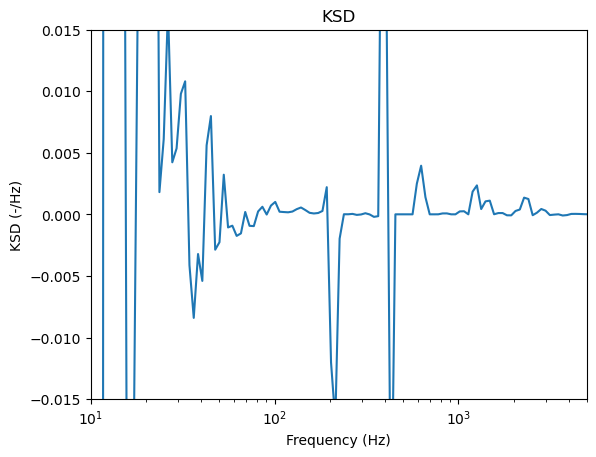

In [22]:
# Graphs

import matplotlib.pyplot as plt
import scipy.io
import numpy as np

# Load MAT file
data = scipy.io.loadmat("Audio-1.mat")
GxxW = data['Gx']
f = data['F']

#Figure 1
# plt.figure(1)

plt.subplot(1, 2, 1)
plt.loglog(f, GxxW, linewidth=1.5)
plt.ylabel('PSD (g^2/Hz)')
plt.xlabel('Frequency (Hz)')
plt.title('PSD of Mixed Signals')

plt.subplot(1, 2, 2)
plt.loglog(f, GxxW[:2], linewidth=1.5)
plt.ylabel('PSD (g^2/Hz)')
plt.xlabel('Frequency (Hz)')
plt.title('PSD from Different Seeds at Different Frequencies')
plt.legend(['Gaussian Process', 'Lognormal Process'], loc='lower left')

# Figure 2
# plt.figure(2)
# plt.clf()

# plt.subplot(2, 2, (1, 2))
# plt.semilogy(faaa, xaaa, linewidth=2, color=[.4, .4, .4])
# plt.semilogy(faaa2, xaaa2, linewidth=2, color=[.7, .7, .7])
# plt.xlim([-20, 10])
# plt.ylim([.000001, 1.1])
# plt.ylabel('Probability Density (log-scale)')
# plt.xlabel('Sample')
# plt.legend(['Gaussian', 'Non-Gaussian'])

# 
# Figure 2 (continued)
# plt.subplot(2, 2, 3)
# plt.plot(tclip, xclip1, color=[.4, .4, .4])
# plt.xlim([0, 2])
# plt.ylim([-10, 10])
# plt.title('Gaussian')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')

# plt.subplot(2, 2, 4)
# plt.plot(tclip, xclip2, color=[.7, .7, .7])
# plt.xlim([0, 2])
# plt.ylim([-10, 10])
# plt.title('Non-Gaussian')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')

# # Figure 3
# plt.figure(3)
# plt.loglog(F, Gxx, f, GxxW[:, 2], linewidth=1.5)
# plt.legend(['Loychik PSD', 'Fourier-Based (Welch) PSD'], loc='lower left')
# plt.title('PSD')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.xlim([10, 5000])

# Figure 4
# plt.figure(4)
# plt.semilogx(F, Sxx1, linewidth=1.5, color=[0, 0.4470, 0.7410])
# plt.title('SSD')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('SSD (-/Hz)')
# plt.xlim([10, 5000])
# plt.ylim([-.004, .004])

# # Figure 5
plt.figure(5)
plt.semilogx(F, Kxx1, linewidth=1.5)
plt.title('KSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('KSD (-/Hz)')
plt.xlim([10, 5000])
plt.ylim([-.015, .015])

plt.show()


In [8]:
from scipy.signal import butter, filtfilt
from scipy.signal import hann, welch
import numpy as np

from scipy.io import wavfile

# Read audio file
sample_rate, audio_data = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/flute_almudena_stability/neumann/0000.wav")

# Use the audio_data as your x3 or whichever variable you want to replace
x3 = audio_data.astype(float)


M, F, Gx, Sx, Kx = loychikSD_NP(x3, Fs, Fbe)

# Power Spectral Density
Gxx = np.gradient(Gx, F)

# Skewness Spectral Density
Sxx2 = np.gradient(Sx, F)

# Kurtosis Spectral Density
Kxx2 = np.gradient(Kx, F)

# Fourth Central Moment Spectral Density
# M4xx = np.gradient(Kx * Gx ** 2, F)

# Clear variables
# del x, x2, x3

# Save variables
scipy.io.savemat("Audio-1.mat", {"M": M, "F": F, "Gx": Gx, "Sx": Sx, "Kx": Kx})

print("MAT file saved. Mission accomplished.")




/var/folders/g8/ryts82jd3c33vl83y_np4dzm0000gn/T/ipykernel_34465/3817508641.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/flute_almudena_stability/neumann/0000.wav")


1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 11

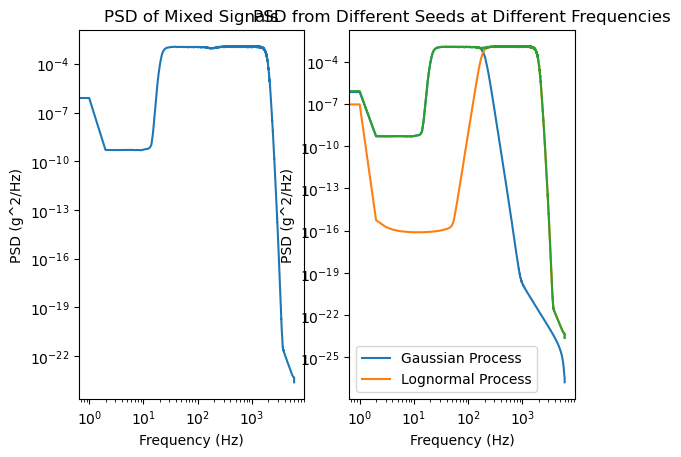

In [9]:
plt.figure(1)

plt.subplot(1, 2, 1)
plt.loglog(f, GxxW[:, 2], linewidth=1.5)
plt.ylabel('PSD (g^2/Hz)')
plt.xlabel('Frequency (Hz)')
plt.title('PSD of Mixed Signals')

plt.subplot(1, 2, 2)
plt.loglog(f, GxxW[:], linewidth=1.5)
plt.ylabel('PSD (g^2/Hz)')
plt.xlabel('Frequency (Hz)')
plt.title('PSD from Different Seeds at Different Frequencies')
plt.legend(['Gaussian Process', 'Lognormal Process'], loc='lower left')

(-0.004, 0.004)

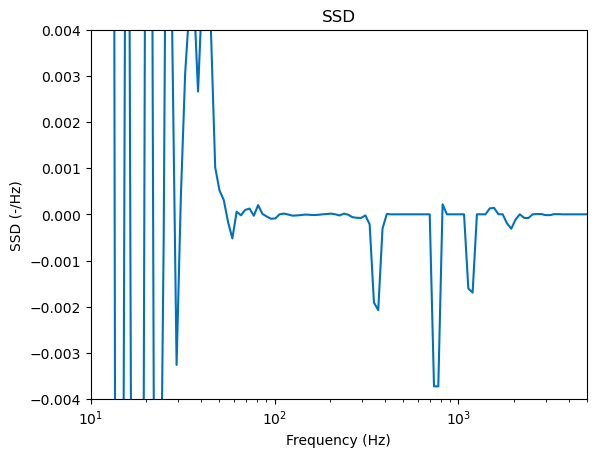

In [27]:
plt.figure(4)
plt.semilogx(F, Sxx2, linewidth=1.5, color=[0, 0.4470, 0.7410])
plt.title('SSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('SSD (-/Hz)')
plt.xlim([10, 5000])
plt.ylim([-.004, .004])

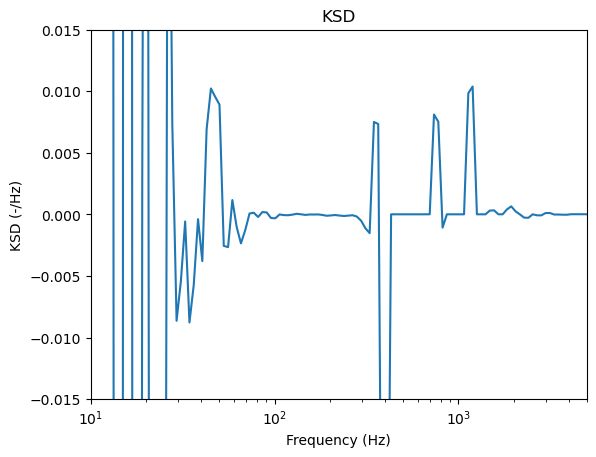

In [30]:
plt.figure(5)
plt.semilogx(F, Kxx2, linewidth=1.5)
plt.title('KSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('KSD (-/Hz)')
plt.xlim([10, 5000])
plt.ylim([-.015, .015])

plt.show()

In [8]:
from scipy.signal import butter, filtfilt
from scipy.signal import hann, welch
import numpy as np

from scipy.io import wavfile

# Read audio file
sample_rate, audio_data = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/trumpet_ramon_pitch_stability/neumann/0000.wav")

# Use the audio_data as your x3 or whichever variable you want to replace
x3 = audio_data.astype(float)


M, F, Gx, Sx, Kx = loychikSD_NP(x3, Fs, Fbe)

# Power Spectral Density
Gxx = np.gradient(Gx, F)

# Skewness Spectral Density
Sxx3 = np.gradient(Sx, F)

# Kurtosis Spectral Density
Kxx3 = np.gradient(Kx, F)

# Fourth Central Moment Spectral Density
# M4xx = np.gradient(Kx * Gx ** 2, F)

# Clear variables
# del x, x2, x3

# Save variables
scipy.io.savemat("Audio-1.mat", {"M": M, "F": F, "Gx": Gx, "Sx": Sx, "Kx": Kx})

print("MAT file saved. Mission accomplished.")




/var/folders/g8/ryts82jd3c33vl83y_np4dzm0000gn/T/ipykernel_23150/3940632841.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/trumpet_ramon_pitch_stability/neumann/0000.wav")


1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 11

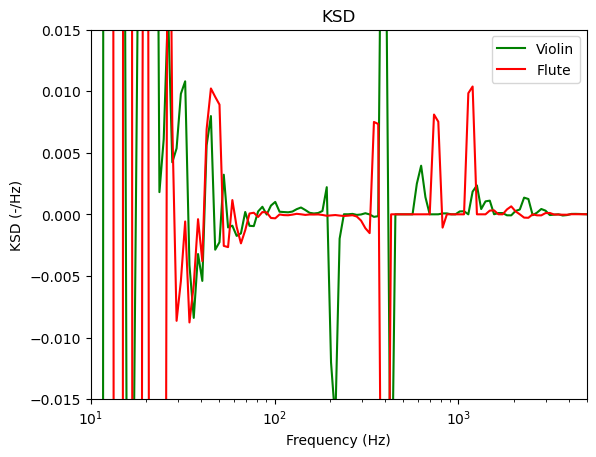

In [19]:
# Graphs

import matplotlib.pyplot as plt
import scipy.io
import numpy as np

# Load MAT file
# data = scipy.io.loadmat("Audio-1.mat")
# print(data)
# GxxW = data['Gx']
# f = data['F']

# Figure 1
# plt.figure(1)

# plt.subplot(1, 2, 1)
# plt.loglog(f, GxxW[:, 2], linewidth=1.5)
# plt.ylabel('PSD (g^2/Hz)')
# plt.xlabel('Frequency (Hz)')
# plt.title('PSD of Mixed Signals')

# plt.subplot(1, 2, 2)
# plt.loglog(f, GxxW[:], linewidth=1.5)
# plt.ylabel('PSD (g^2/Hz)')
# plt.xlabel('Frequency (Hz)')
# plt.title('PSD from Different Seeds at Different Frequencies')
# plt.legend(['Gaussian Process', 'Lognormal Process'], loc='lower left')

# Figure 2
# plt.figure(2)
# plt.clf()

# plt.subplot(2, 2, (1, 2))
# plt.semilogy(faaa, xaaa, linewidth=2, color=[.4, .4, .4])
# plt.semilogy(faaa2, xaaa2, linewidth=2, color=[.7, .7, .7])
# plt.xlim([-20, 10])
# plt.ylim([.000001, 1.1])
# plt.ylabel('Probability Density (log-scale)')
# plt.xlabel('Sample')
# plt.legend(['Gaussian', 'Non-Gaussian'])

# 
# Figure 2 (continued)
# plt.subplot(2, 2, 3)
# plt.plot(tclip, xclip1, color=[.4, .4, .4])
# plt.xlim([0, 2])
# plt.ylim([-10, 10])
# plt.title('Gaussian')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')

# plt.subplot(2, 2, 4)
# plt.plot(tclip, xclip2, color=[.7, .7, .7])
# plt.xlim([0, 2])
# plt.ylim([-10, 10])
# plt.title('Non-Gaussian')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')

# # Figure 3
# plt.figure(3)
# plt.loglog(F, Gxx, f, GxxW[:, 2], linewidth=1.5)
# plt.legend(['Loychik PSD', 'Fourier-Based (Welch) PSD'], loc='lower left')
# plt.title('PSD')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.xlim([10, 5000])

# Figure 4
# plt.figure(4)
# plt.semilogx(F, Sxx1, linewidth=1.5,  color='green',label="Violin")
# plt.semilogx(F, Sxx2, linewidth=1.5, color='red',label = "Flute")
# # plt.semilogx(F, Sxx3, linewidth=1.5, color='blue',label = "Trumpet")

# # plt.semilogx(F, Sxx3, linewidth=1.5, color='blue')
# plt.title('SSD')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('SSD (-/Hz)')
# plt.xlim([10, 5000])
# plt.ylim([-.004, .004])
# plt.legend(labels=["Violin", "Flute","Trumpet"])

# # Figure 5
plt.figure(5)
plt.semilogx(F, Kxx1, linewidth=1.5,color='green',label="Violin")
plt.semilogx(F, Kxx2, linewidth=1.5,color='red',label="Flute")
# plt.semilogx(F, Kxx3, linewidth=1.5,color='blue',label="Trumpet")

plt.title('KSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('KSD (-/Hz)')
plt.xlim([10, 5000])
plt.ylim([-.015, .015])
plt.legend(labels=["Violin", "Flute","Trumpet"])

plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# Simulated waveform data for 3 different instruments (0, 1, 2)
# Each sample is a waveform with 1000 data points
n_samples = 1000
n_data_points = 1000
n_classes = 3

# Generate some example data
#X = np.random.rand(n_samples, n_data_points, 1)  # Replace with your actual waveform data
X = Sxx1
y = np.random.randint(0, n_classes, n_samples)  # Replace with your actual labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create 1D CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_data_points, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

# Sample data
x = np.linspace(0, 2 * np.pi, 100)  # Generate 100 points from 0 to 2*pi
plots = {
    'Sine': np.sin(x),
    'Cosine': np.cos(x),
    'Tangent': np.tan(x)
}

def plot_func(choice):
    # Set up the plot
    plt.figure(figsize=(8, 6))
    plt.plot(x, plots[choice], label=choice)
    
    # Set plot limits for Tangent
    if choice == 'Tangent':
        plt.ylim(-5, 5)
    
    # Add title and labels
    plt.title(f'{choice} Plot')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)
    plt.show()

# Dropdown menu
interact(plot_func, choice=widgets.Dropdown(options=plots.keys(), value='Sine', description='Select Plot:'))


interactive(children=(Dropdown(description='Select Plot:', options=('Sine', 'Cosine', 'Tangent'), value='Sine'…

<function __main__.plot_func(choice)>